## Project: Build a Traffic Sign Recognition Classifier

Author : Mouad HADJI, November 11th, 2017

In this project, I will explain how to 

---
## 1. Import packages

In this section, we import the packages we will use throughout the project. If there is the need for other packages, we will load them later.

In [1]:
import os
import sys
import glob
import pickle
import cv2
import random
from scipy import ndimage
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 2. Load The Data

We first load the 3 datasets (train, validation, test) that will allow us to train, measure the performance and evaluate our classifier. Since we will try training on both local machine and a GPU instance, we use a clean notation of paths.

In [2]:
project_path = os.path.join(os.environ['HOME'], "sdcnd/sdcnd_traffic_sign_classifier")
data_path = os.path.join(project_path, "traffic-signs-data")
model_path = os.path.join(project_path, "models")
new_images_path = os.path.join(project_path, "images")

In [3]:
training_file = os.path.join(data_path, "train.p")
validation_file= os.path.join(data_path, "valid.p")
testing_file = os.path.join(data_path, "test.p")

In [4]:
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [5]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## 3. Data Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

In [6]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)

image_shape = train['features'][0].shape

n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


`sign_names` contains the names of the names. Let's load it and check out the label names

In [7]:
sign_names = pd.read_csv(os.path.join(project_path, "signnames.csv"))
sign_names.set_index("ClassId", inplace=True)
sign_dict = sign_names.SignName.to_dict()

In [8]:
sign_dict

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

### Visualize the dataset :

In [9]:
def show_images(images, n_row, n_col, labels=None, cmap=None):

    fig, ax = plt.subplots(n_row, n_col, figsize=(15, 6))
    ax = ax.ravel()
    n_images = n_row*n_col
    
    for i, image in enumerate(images):
        plt.subplot(n_row, n_col, i+1)
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [10]:
demo_index = list(np.random.randint(0, len(X_train) + 1, 6))
demo_images = [X_train[i] for i in demo_index]
demo_labels = [sign_dict[y_train[i]] for i in demo_index]

In [11]:
print(demo_labels)

['Stop', 'Ahead only', 'No passing', 'Priority road', 'Stop', 'Road work']


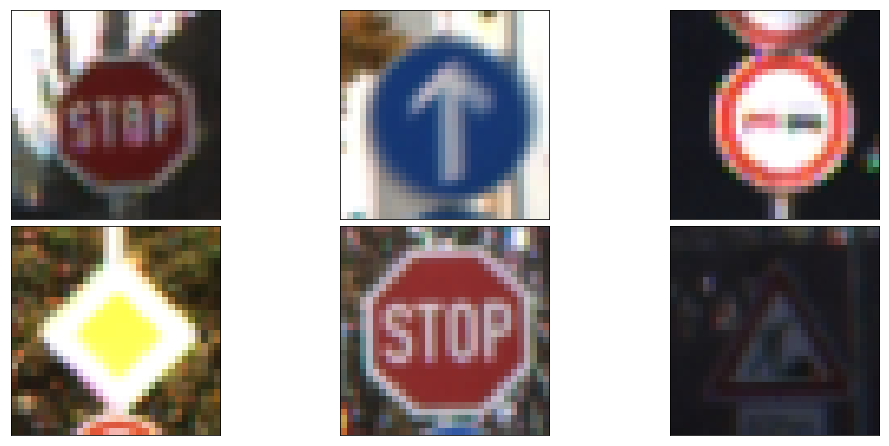

In [12]:
show_images(demo_images, 2, 3, labels=demo_labels)

#### Plotting a sample of traffic signs

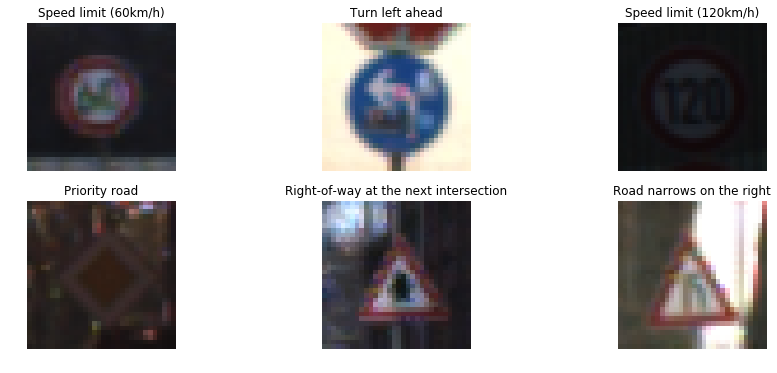

In [13]:
fig, ax = plt.subplots(2,3, figsize=(15, 6))
ax = ax.ravel()
for i in range(6):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_title(sign_dict[y_train[index]])

#### Plotting the distribution of the classes

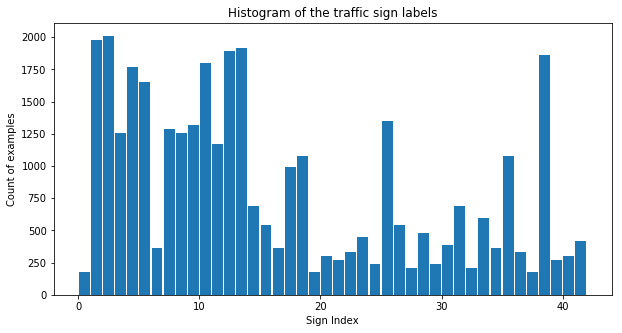

In [14]:
plt.figure(figsize=(10,5))
plt.xlabel("Sign Index")
plt.ylabel("Count of examples")
plt.hist(y_train, bins=list(range(n_classes)), rwidth=0.9)
plt.title("Histogram of the traffic sign labels")
plt.show()

We can note that the dataset is not balanced at all. This is not optimal but hopefully we can achieve great performance with this imbalanced dataset.

----

## 4. Design and Test a Model Architecture

Let us now design and implement a deep learning model that learns to recognize traffic signs. We will implement this in different steps :

- First, we will create a pipeline for **pre-processing** the images (normalize, grayscale, etc.)
- Besides, we will **enhance our dataset** by implementing dataset augmentation
- Then, we will proceed to the **design** of our deep learning model by taking inspiration in the LeNet architecture
- Eventually, we will **measure the performance** of our model

### 4.i. Pre-process the images

In this step, we want to pre-process the image data. They are several transformation we can implement : normalization, grayscale, etc. We will implement several of them below.

In [15]:
def normalize(img):
    return (img - np.mean(img))/np.std(img)

In [16]:
def gray_scale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [17]:
def pre_process_img(img):
    img_1 = normalize(img)
    img_2 = gray_scale(img)
    return img_2

In [18]:
demo_images_preprocessed = [pre_process_img(img) for img in demo_images]
demo_images_preprocessed[0].shape

(32, 32)

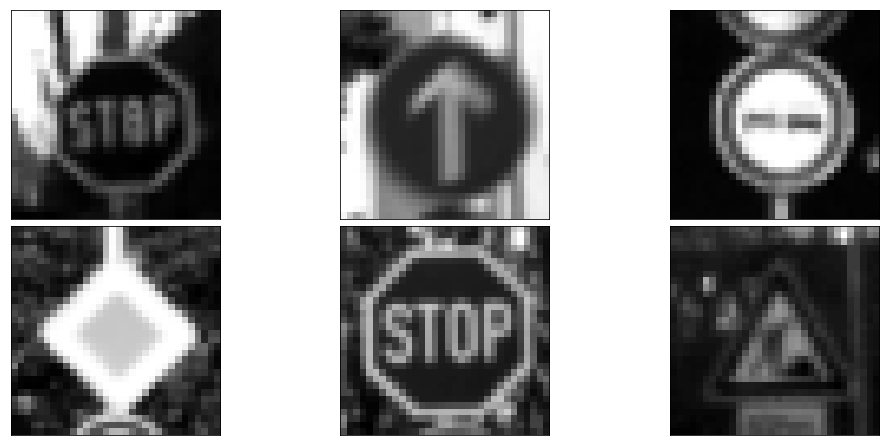

In [19]:
show_images(demo_images_preprocessed, 2, 3, labels=demo_labels)

### 4.iI. Augment the dataset

Xxx

In [20]:
class AugmentationEffect:

    def translate(self, img):
        x, y, z = img.shape
        max_px = 0.2
        dx = np.random.uniform(-max_px * x, max_px * x)
        dy = np.random.uniform(-max_px * y, max_px * y)
        translated_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
        translated_img = cv2.warpAffine(img, translated_matrix, (x, y))
        return translated_img
    
    def scale(self, img):   
        x, y, z = img.shape
        max_scale = np.random.randint(-2,2)
        # ending locations
        pts1 = np.float32([[max_scale, max_scale], [x - max_scale, max_scale], [max_scale, y - max_scale], [x - max_scale, y - max_scale]])
        # starting locations (4 corners)
        pts2 = np.float32([[0,0],[x,0],[0,y],[x,y]])
        M = cv2.getPerspectiveTransform(pts1,pts2)
        scaled_img = cv2.warpPerspective(img,M,(x,y))
        return scaled_img

    def rotate(self, img):
        x, y, z = img.shape
        angle = np.random.uniform(-60, 60)
        rotation_center = (x / 2, y / 2)
        rotation_matrix = cv2.getRotationMatrix2D(rotation_center, angle, 1)
        rotated_img = cv2.warpAffine(img, rotation_matrix, (x, y))
        return rotated_img

    def blur(self, img):
        r_int = np.random.randint(0, 2)
        odd_size = 2 * r_int + 1
        return cv2.GaussianBlur(img, (odd_size, odd_size), 0)
    
    def run_random(self, img):
        random_choice = np.random.randint(4)
        function_map = dict(zip(range(4),[self.translate, self.scale, self.rotate, self.blur]))
        return function_map[random_choice](img)

In [21]:
AE = AugmentationEffect()

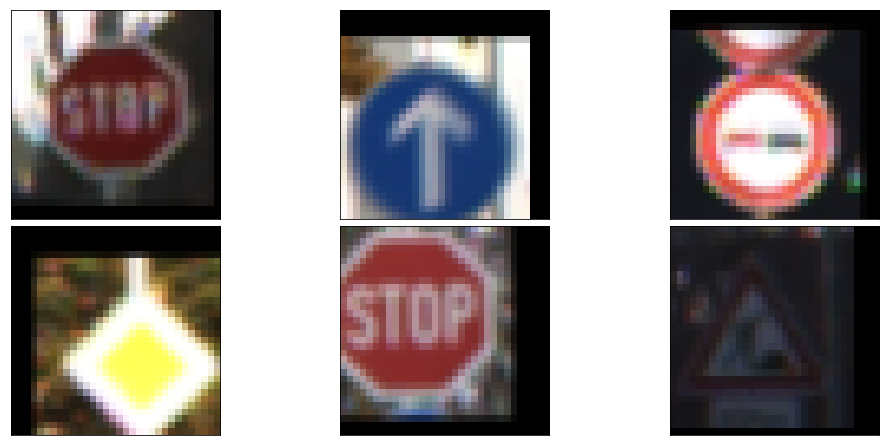

In [24]:
demo_images_translated = [AE.translate(img) for img in demo_images]
show_images(demo_images_translated, 2, 3, labels=demo_labels)

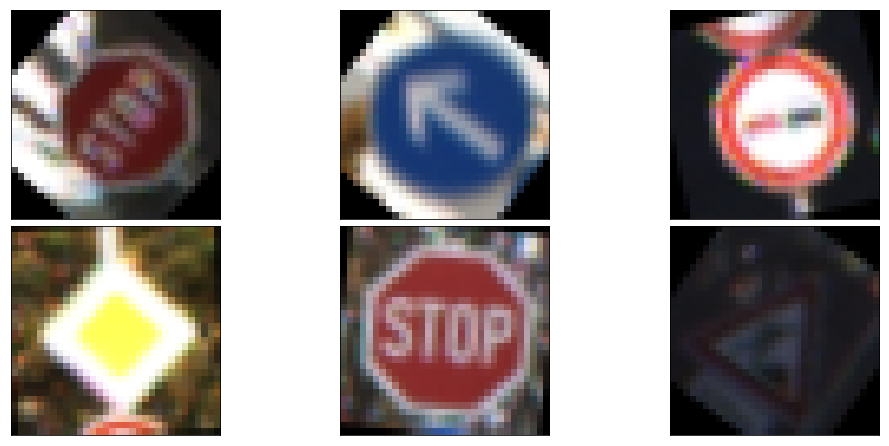

In [25]:
demo_images_rotated = [AE.rotate(img) for img in demo_images]
show_images(demo_images_rotated, 2, 3, labels=demo_labels)

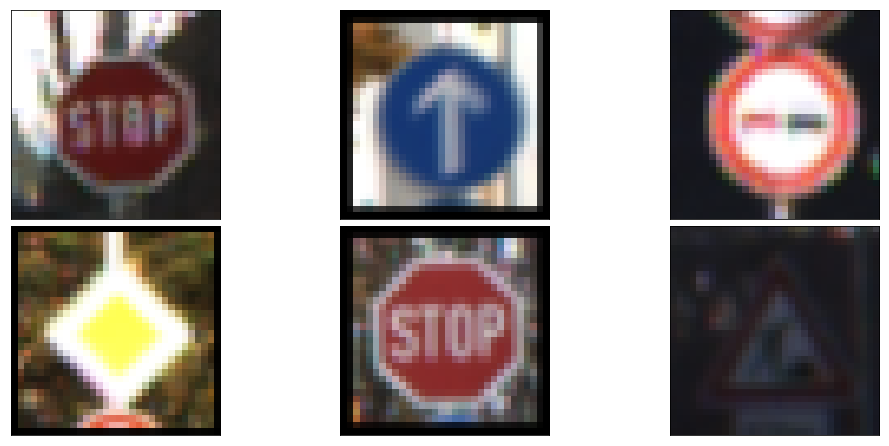

In [26]:
demo_images_scaled = [AE.scale(img) for img in demo_images]
show_images(demo_images_scaled, 2, 3, labels=demo_labels)

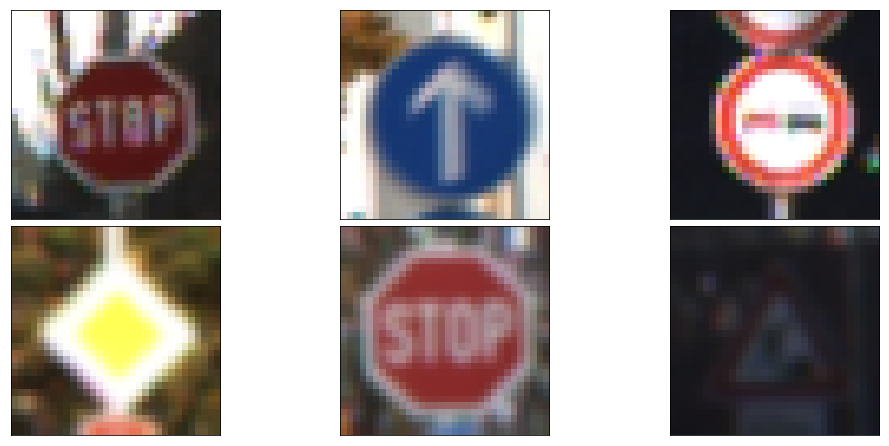

In [27]:
demo_images_blurred = [AE.blur(img) for img in demo_images]
show_images(demo_images_blurred, 2, 3, labels=demo_labels)

Now that we introduced multiple transformations that we can use to augment our dataset, let us use them to balance our dataset. Let us bring the number of training examples to 1000 per class.

In [28]:
class AugmentDataset:
    
    def __init__(self, data_path): 
        #self.train_data = self.load_data(data_path)
        self.data_path = data_path
        self.ae = AugmentationEffect()   

    def load_data(self):
        training_file = os.path.join(self.data_path, "train.p")
        with open(training_file, 'rb') as f:
            train = pickle.load(f)
        return train
    
    def save_data(self):
        output_path = os.path.join(self.data_path, "train_new.p")
        with open(output_path, 'wb') as f:
            pickle.dump({"features":self.X_train_new, "labels":self.y_train_new} , f)
        return True
    
    def run(self):
        
        train_data = self.load_data()
        
        self.X_train = train_data['features']
        self.y_train = train_data['labels']
        
        n_labels = len(set(self.y_train))
        ts, imgs_per_sign = np.unique(self.y_train, return_counts=True)
        avg_image_per_class = round(np.mean(imgs_per_sign))
        
        X_train_new = []
        y_train_new = []
        
        for label in tqdm(range(n_labels)):
            img_label_idx = np.where(self.y_train == label)[0]
            count_examples = len(img_label_idx)
            count_to_add = np.int(avg_image_per_class - count_examples)
            
            
            if count_to_add <= 0 :
                new_images = list(self.X_train[img_label_idx])
                new_labels = list(self.y_train[img_label_idx])
            else:
                selected_idx = np.random.choice(img_label_idx, count_to_add)
                added_images = np.array([self.ae.run_random(img) for img in list(X_train[selected_idx])])
                
                new_images = list(self.X_train[img_label_idx]) + list(added_images)
                new_labels = list(np.repeat(label, len(new_images)))
            X_train_new = X_train_new + new_images
            y_train_new = y_train_new + new_labels
            
        self.X_train_new = np.array(X_train_new)
        self.y_train_new = np.array(y_train_new)
        
        self.save_data()

In [29]:
AD = AugmentDataset(data_path)
AD.run()

100%|██████████| 43/43 [00:00<00:00, 86.87it/s] 


In [30]:
training_file_new = os.path.join(data_path, "train_new.p")

with open(training_file_new, mode='rb') as f:
    train_new = pickle.load(f)
    
X_train = train_new["features"]
y_train = train_new["labels"]

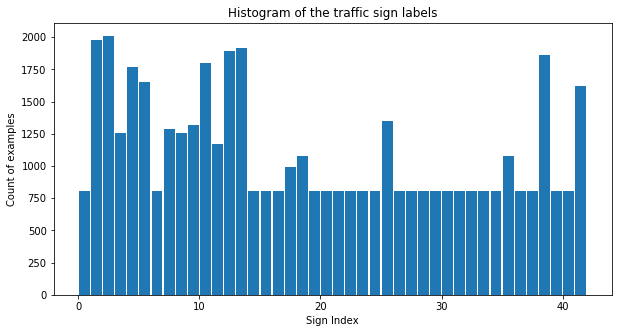

In [32]:
plt.figure(figsize=(10,5))
plt.xlabel("Sign Index")
plt.ylabel("Count of examples")
plt.hist(y_train, bins=list(range(n_classes)), rwidth=0.9)
plt.title("Histogram of the traffic sign labels")
plt.show()

Here, we do the basic pre-processing we entended to do with the training data.

In [33]:
from sklearn.utils import shuffle

In [34]:
X_train, y_train = shuffle(X_train, y_train)

In [35]:
X_train = np.array([pre_process_img(img) for img in X_train])
X_valid = np.array([pre_process_img(img) for img in X_valid])
X_test = np.array([pre_process_img(img) for img in X_test])

In [36]:
X_train = X_train[:,:,:,np.newaxis]
X_valid = X_valid[:,:,:,np.newaxis]
X_test = X_test[:,:,:,np.newaxis]

### 4.iii. Model Architecture

In this example, we will implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture. We will describe below all the details of the model architecture.

#### Inputs

The number of color channels here is `3`. If we decide to grayscale, the number of channels will be reduced to `1`. The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels.

#### Outputs

The number of classes to label is 43. Hence the length of Logits layer will be 43.

#### Architecture :  5 Layers (CONV-POOL, CONV-POOL, FC, FC, FC)

**Layer 1: Convolutional.** The output shape should be 28x28x6.
**Activation.** RELU.
**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.
**Activation.** RELU.
**Pooling.** The output shape should be 5x5x16.
**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

**Layer 3: Fully Connected.** This should have 120 outputs.
**Activation.** RELU.

**Layer 4: Fully Connected.** This should have 84 outputs.
**Activation.** RELU.

**Layer 5: Fully Connected (Logits).** This should have 43 outputs.

In [37]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

Let's define here the basic **CONV** and **POOL** layers that we will use multiple times : 

In [38]:
def conv2d(x, weights, biases, strides=1, padding='VALID'):
    conv = tf.nn.conv2d(x, weights, strides=[1, strides, strides, 1], padding=padding)
    conv = tf.add(conv, biases)
    return conv

def maxpool2d(x, k=2, padding='VALID'):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding=padding)

In [39]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    ########################## LAYER 1
    
    w_1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    b_1 = tf.Variable(tf.zeros(6))
    
    conv1 = conv2d(x, w_1, b_1, strides=1) # Convolution. Input = 32x32x3. Output = 28x28x6.
    conv1 = tf.nn.relu(conv1) # Activation
    conv1 = maxpool2d(conv1, k=2) # Pooling. Input = 28x28x6. Output = 14x14x6.
    
    ########################## LAYER 2
    
    w_2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    b_2 = tf.Variable(tf.zeros(16))
    
    conv2 = conv2d(conv1, w_2, b_2, strides=1) # Convolution. Input = 14x14x16. Output = 10x10x16.
    conv2 = tf.nn.relu(conv2) # Activation
    conv2 = maxpool2d(conv2, k=2) # Pooling. Input = 10x10x16. Output = 5x5x16.

    fc0   = flatten(conv2) # Flatten. Input = 5x5x16. Output = 400.
    
    ########################## LAYER 3
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b # Fully Connected. Input = 400. Output = 120.
    
    fc1    = tf.nn.relu(fc1) # Activation.
    
    ########################## LAYER 4

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b # Fully Connected. Input = 120. Output = 84.
    
    fc2    = tf.nn.relu(fc2) # Activation.
    
    ########################## LAYER 5

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    
    logits = tf.matmul(fc2, fc3_W) + fc3_b # Fully Connected. Input = 84. Output = 43.
    
    return logits

### 4.iii. Training and Evaluation Pipelines

In this section, we define the inputs (features = images) and outputs (labels = categories) for the tensorflow model :
    
- `x` is a placeholder for a batch of input images.
- `y` is a placeholder for a batch of output labels.

In [40]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

The `RATE`, `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [42]:
RATE = 0.001
EPOCHS = 25
BATCH_SIZE = 128

In [43]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = RATE)
training_operation = optimizer.minimize(loss_operation)

For the evaluation, we will use the following function to compute the acuuracy of the trained model :

In [44]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [45]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### 4.iv. Train and Validate the Model

This section will run the training data through the training pipeline to train the model. It follows multiple steps :

- Before each epoch, shuffle the training set.
- After each epoch, measure the loss and accuracy of the validation set.
- Save the model after training.

In [46]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    
    training_acc_hist = []
    validation_acc_hist = []
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        training_accuracy = sess.run(accuracy_operation, feed_dict={x: X_train, y: y_train, keep_prob: 1.0})
        validation_accuracy = sess.run(accuracy_operation, feed_dict={x: X_valid, y: y_valid, keep_prob: 1.0})
        
        training_acc_hist.append(training_accuracy)
        validation_acc_hist.append(validation_accuracy)
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, model_path)
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.756
Validation Accuracy = 0.746

EPOCH 2 ...
Training Accuracy = 0.843
Validation Accuracy = 0.806

EPOCH 3 ...
Training Accuracy = 0.890
Validation Accuracy = 0.831

EPOCH 4 ...
Training Accuracy = 0.924
Validation Accuracy = 0.854

EPOCH 5 ...
Training Accuracy = 0.924
Validation Accuracy = 0.856

EPOCH 6 ...
Training Accuracy = 0.940
Validation Accuracy = 0.857

EPOCH 7 ...
Training Accuracy = 0.953
Validation Accuracy = 0.868

EPOCH 8 ...
Training Accuracy = 0.955
Validation Accuracy = 0.866

EPOCH 9 ...
Training Accuracy = 0.955
Validation Accuracy = 0.864

EPOCH 10 ...
Training Accuracy = 0.963
Validation Accuracy = 0.873

EPOCH 11 ...
Training Accuracy = 0.954
Validation Accuracy = 0.866

EPOCH 12 ...
Training Accuracy = 0.964
Validation Accuracy = 0.871

EPOCH 13 ...
Training Accuracy = 0.972
Validation Accuracy = 0.887

EPOCH 14 ...
Training Accuracy = 0.967
Validation Accuracy = 0.885

EPOCH 15 ...
Training Accuracy = 0.977
Valid

#### Validation of the model

### 4.v. Evaluate the Model (using test set)

In [96]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.894


---

## 5. Test our Model on New Images

We can know check the performance of our model on random pictures of German traffic signs downloaded from the Internet.

### 5.i. Load and Output the Images

In [97]:
def read_image(image_path):
    img = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_shape[0], image_shape[1]))
    return img

In [98]:
def show_images(images, cmap=None, labels=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
        if labels is not None:
            plt.title(sign_dict[labels[i]])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [99]:
new_labels = [11, 1, 12, 14, 25, 33]

In [100]:
new_images = [read_image(os.path.join(new_images_path, 'test_image_' + str(i + 1) + '.jpg')) for i in list(range(6))]

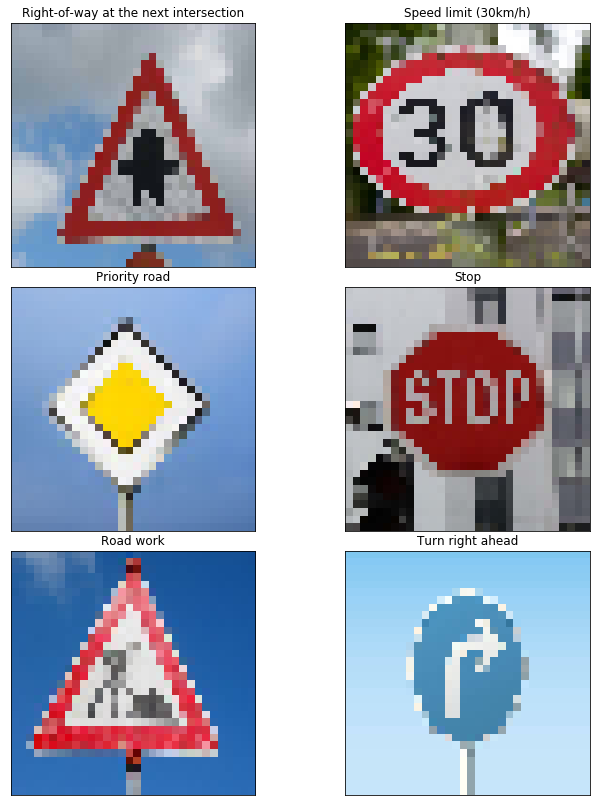

In [101]:
show_images(new_images, labels=new_labels)

### 5.ii. Predict the Sign Type for Each Image

In [102]:
new_images_processed = [pre_process_img(img) for img in new_images]
X_new_images = np.array(new_images_processed)[:,:,:, np.newaxis]

In [103]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    new_img_accuracy = evaluate(X_new_images, new_labels)
    print("New Image Accuracy = {:.3f}".format(new_img_accuracy))

New Image Accuracy = 0.333


### 5.iii. Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, let's print out the model's softmax probabilities to show the **certainty** of the model's predictions (we will limit the output to the top 5 probabilities for each image). For this purpose, we will use the  [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) function.

In [104]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    logits = sess.run([tf.nn.softmax(logits)], feed_dict={x: X_new_images, y: new_labels, keep_prob: 1.0})
    print("Test Accuracy = {:.3f}".format(new_img_accuracy))

ValueError: Argument must be a dense tensor: [array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.04697394e-19,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.88202890e-30,   0.00000000e+00,
          3.19072454e-37,   0.00000000e+00,   0.00000000e+00,
          6.85963255e-33,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  7.37496730e-10,   5.84887346e-07,   2.84087653e-20,
          3.08882626e-14,   4.53493177e-27,   3.31820943e-03,
          1.89794693e-21,   0.00000000e+00,   9.21961283e-18,
          0.00000000e+00,   0.00000000e+00,   9.96681154e-01,
          0.00000000e+00,   1.49249340e-26,   2.99547061e-15,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          8.14183785e-18,   0.00000000e+00,   1.19659039e-37,
          2.91166313e-10,   0.00000000e+00,   7.77489523e-33,
          0.00000000e+00,   2.33334847e-21,   1.47763055e-38,
          0.00000000e+00,   1.22733035e-27,   3.68551127e-11,
          0.00000000e+00,   6.41053989e-21,   0.00000000e+00,
          0.00000000e+00,   3.41394640e-23,   3.61590701e-35,
          0.00000000e+00,   5.64489327e-26,   4.20822173e-23,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.05210210e-35,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.41467531e-23,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.57104205e-23,   0.00000000e+00,
          0.00000000e+00],
       [  1.77843341e-12,   2.47720542e-04,   1.18657326e-05,
          8.76226116e-19,   1.06578205e-16,   3.57960737e-08,
          1.35164480e-09,   1.61663495e-11,   4.02387232e-05,
          1.23595065e-10,   1.66881676e-07,   3.82666433e-11,
          1.32781324e-07,   5.36660582e-06,   3.94160040e-02,
          1.09173220e-21,   6.67778116e-13,   3.10022392e-06,
          1.54355850e-21,   9.65988772e-16,   5.77242074e-12,
          1.75556597e-20,   4.68787863e-28,   1.08317862e-13,
          7.92834891e-25,   8.08864187e-17,   5.16086089e-12,
          1.76706541e-31,   6.76562070e-11,   7.55616751e-18,
          1.61989838e-10,   5.17844671e-14,   7.57462258e-05,
          4.04896871e-19,   2.30414118e-10,   2.80848808e-15,
          1.37234928e-16,   5.81625960e-17,   6.20460371e-04,
          7.75719788e-17,   1.02652839e-05,   9.59568918e-01,
          9.51721812e-09],
       [  1.70990053e-36,   1.31239576e-16,   0.00000000e+00,
          1.52590110e-22,   0.00000000e+00,   2.35185538e-10,
          0.00000000e+00,   7.77921296e-33,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.09128716e-28,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.04432571e-34,   0.00000000e+00,   8.80369210e-30,
          2.21418429e-30,   4.63797967e-12,   1.26349502e-18,
          7.27800057e-07,   9.65543270e-01,   0.00000000e+00,
          0.00000000e+00,   7.98068056e-21,   3.44559960e-02,
          3.12216121e-11,   1.05931889e-28,   0.00000000e+00,
          0.00000000e+00,   3.54126647e-38,   9.74552538e-26,
          0.00000000e+00,   1.10066183e-18,   1.19835795e-34,
          0.00000000e+00,   5.70048439e-38,   0.00000000e+00,
          0.00000000e+00],
       [  3.10460296e-10,   4.06469173e-12,   1.57309998e-09,
          1.19101769e-05,   2.88170270e-17,   1.54332633e-06,
          9.84946033e-04,   1.03098250e-11,   8.92231574e-14,
          8.32832970e-20,   4.01996348e-28,   1.14738801e-03,
          3.20314908e-09,   3.87446391e-21,   2.35665193e-13,
          1.57450312e-30,   2.48098277e-05,   5.28799262e-36,
          7.04175813e-13,   5.87773212e-28,   1.10239616e-05,
          7.98676138e-27,   0.00000000e+00,   2.31004541e-15,
          2.45816775e-15,   1.29307490e-34,   4.36333400e-11,
          3.25481273e-25,   2.76874744e-07,   1.24446204e-04,
          9.88280903e-22,   6.81241393e-35,   9.96958852e-01,
          5.67991752e-04,   1.84308715e-28,   1.64464465e-04,
          1.07428922e-34,   4.77858414e-19,   9.00434241e-14,
          6.66193113e-24,   2.38561825e-06,   7.76971972e-15,
          4.46965754e-17]], dtype=float32)] - got shape [1, 6, 43], but wanted [1].

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")